In [1]:
import torch
from math import pi
import einops as einops
from training.utils.FLAIR_2 import*
import matplotlib.pyplot as plt
from training.perceiver import*
from training.utils import*
from training.losses import*
from training.VIT import*
from training.ResNet import*
from collections import defaultdict
from training import*

/Users/hugoriffaud/Documents/FLAIR_Ato/venv/lib/python3.11/site-packages/albumentations/check_version.py:107: UserWarning: Error fetching version info <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)>
  data = fetch_version_info()


/var/folders/kh/8xx46fmx42n0vd2989f_jgwr0000gn/T/ipykernel_6507/1040173336.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


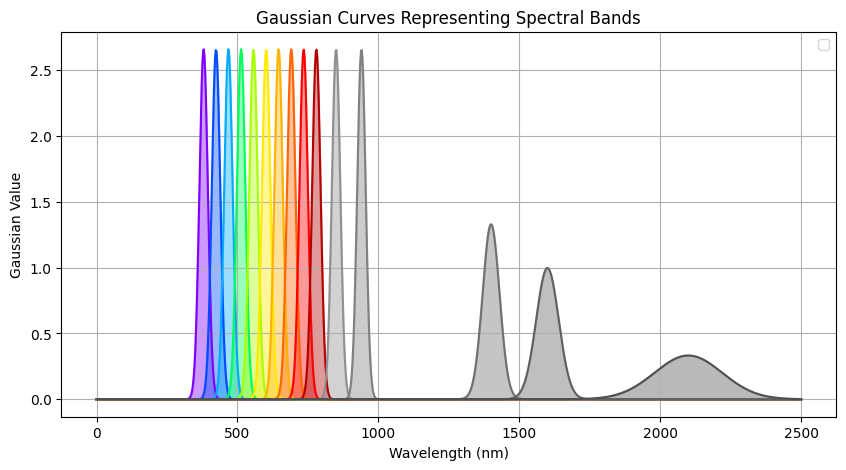

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_gaussians_with_fill(centers, stds,colors, num_points=1000):
    """
    Plots multiple Gaussian curves with shaded areas under each curve.

    Parameters:
    - centers: List of mean values for each Gaussian.
    - stds: List of standard deviations for each Gaussian.
    - num_points: Number of points to sample in the range.
    """
    x = np.linspace(0, 2500, num_points)  # Extended range to fit all wavelengths
    
    plt.figure(figsize=(10, 5))
    
    for idx,(mu, sigma) in enumerate(zip(centers, stds)):
        y = np.exp(-0.5 * ((x - mu) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi)) * 100
        plt.plot(x, y,color=colors[idx])#label=f'$\mu$={mu}, $\sigma$={sigma}'
        plt.fill_between(x, y, alpha=0.4,color=colors[idx])  # Fill area under the curve
    
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Gaussian Value")
    plt.title("Gaussian Curves Representing Spectral Bands")
    plt.legend()
    plt.grid()
    plt.show()

# Central wavelengths (centers of Gaussians)
VIS=[380, 424, 468, 513, 557, 602, 646, 691, 735, 780,850,940]
middle=[1400,1600]
centers = VIS+middle+[2100]

# Bandwidths (used as standard deviations)
VIS_std=[15,15,15,15,15,15,15,15,15,15,15,15]
middle_std=[30,40]
stds = VIS_std+middle_std+[120]
colors = [
    '#8000ff',  # 380 nm (Violet)
    '#004cff',  # 424 nm (Deep Blue)
    '#00aaff',  # 468 nm (Cyan-Blue)
    '#00ff59',  # 513 nm (Green-Cyan)
    '#a8ff00',  # 557 nm (Green-Yellow)
    '#ffea00',  # 602 nm (Yellow)
    '#ffb300',  # 646 nm (Orange)
    '#ff6500',  # 691 nm (Red-Orange)
    '#ff0000',  # 735 nm (Deep Red)
    '#b30000',  # 780 nm (Very Deep Red)
    '#909090',  # 850 nm (NIR, grey)
    '#808080',  # 940 nm (NIR, darker grey)
    '#707070',  # 1030 nm
    '#606060',  # 1200 nm
    '#505050',  # 1400 nm
    '#404040',  # 1600 nm
    '#303030'   # 2100 nm
]


# Plot the Gaussians with filled areas
plot_gaussians_with_fill(centers, stds,colors)


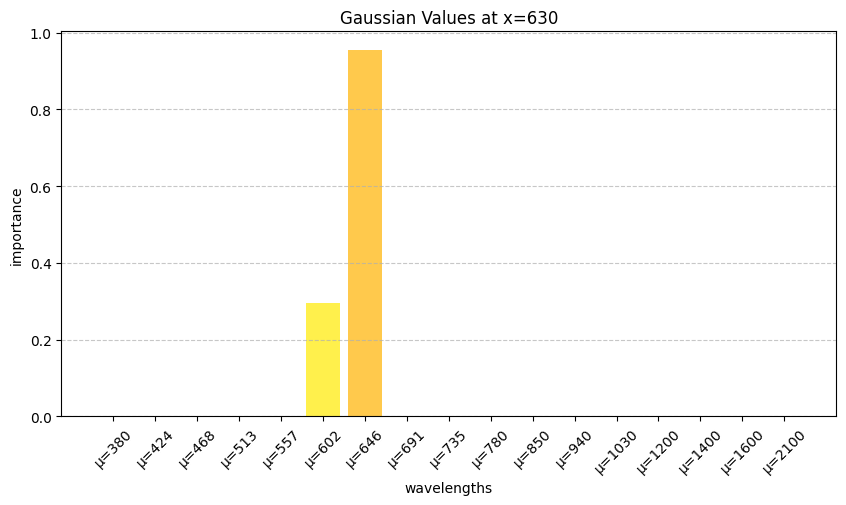

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def compute_gaussian_values(x, centers, stds):
    """
    Computes the value of each Gaussian function at a given x.

    Parameters:
    - x: The input value at which to evaluate the Gaussians.
    - centers: List of mean values for each Gaussian.
    - stds: List of standard deviations for each Gaussian.

    Returns:
    - List of Gaussian function values at x.
    """
    gaussian_values = [
        np.exp(-0.5 * ((x - mu) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi)) * 100
        for mu, sigma in zip(centers, stds)
    ]
    return gaussian_values

# Given parameters
# Central wavelengths (centers of Gaussians)
centers = [380, 424, 468, 513, 557, 602, 646, 691, 735, 780,850,940,1030,1200,1400,1600,2100]

# Bandwidths (used as standard deviations)
stds = [15,15,15,15,15,15,15,15,15,15,30,40,50,70,80,100,120]
colors = [
    '#8000ff',  # 380 nm (Violet)
    '#004cff',  # 424 nm (Deep Blue)
    '#00aaff',  # 468 nm (Cyan-Blue)
    '#00ff59',  # 513 nm (Green-Cyan)
    '#a8ff00',  # 557 nm (Green-Yellow)
    '#ffea00',  # 602 nm (Yellow)
    '#ffb300',  # 646 nm (Orange)
    '#ff6500',  # 691 nm (Red-Orange)
    '#ff0000',  # 735 nm (Deep Red)
    '#b30000',  # 780 nm (Very Deep Red)
    '#909090',  # 850 nm (NIR, grey)
    '#808080',  # 940 nm (NIR, darker grey)
    '#707070',  # 1030 nm
    '#606060',  # 1200 nm
    '#505050',  # 1400 nm
    '#404040',  # 1600 nm
    '#303030'   # 2100 nm
]
# Example x value
x_value = 630

# Compute Gaussian values at x
gaussian_values_at_x = compute_gaussian_values(x_value, centers, stds)
gaussian_values_at_x/= np.linalg.norm(gaussian_values_at_x, ord=2) + 1e-8
# Plot bar chart
plt.figure(figsize=(10, 5))
plt.bar(range(len(centers)), gaussian_values_at_x, color=colors, alpha=0.7)

# Labeling
plt.xticks(range(len(centers)), [f'μ={mu}' for mu in centers], rotation=45)
plt.xlabel("wavelengths")
plt.ylabel("importance")
plt.title(f"Gaussian Values at x={x_value}")

# Show plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [37]:
import numpy as np

def compute_gaussian_band_encoding(lambda_center, bandwidth, centers, stds, num_points=50):
    """
    Compute Gaussian encoding averaged over a wavelength bandwidth.

    Parameters:
    - lambda_center: central wavelength of the spectral band
    - bandwidth: total width of the spectral band
    - centers: list or array of Gaussian centers (means)
    - stds: list or array of Gaussian standard deviations
    - num_points: number of points to sample within the bandwidth (higher for accuracy)

    Returns:
    - encoding: np.array of averaged Gaussian values
    """
    # Define the range covered by the bandwidth
    lambda_min = lambda_center - bandwidth / 2
    lambda_max = lambda_center + bandwidth / 2
    
    # Sample wavelengths within the bandwidth range
    sampled_lambdas = np.linspace(lambda_min, lambda_max, num_points).reshape(-1, 1)

    # Convert Gaussian centers and stds to numpy arrays and reshape
    centers = np.array(centers).reshape(1, -1)
    stds = np.array(stds).reshape(1, -1)

    # Efficiently compute Gaussian values for all sampled wavelengths (vectorized)
    gaussians = np.exp(-0.5 * ((sampled_lambdas - centers) / stds) ** 2)

    # Average the Gaussian responses across the bandwidth
    encoding = gaussians.max(axis=0)
    encoding/= np.linalg.norm(encoding, ord=2) + 1e-8

    return encoding


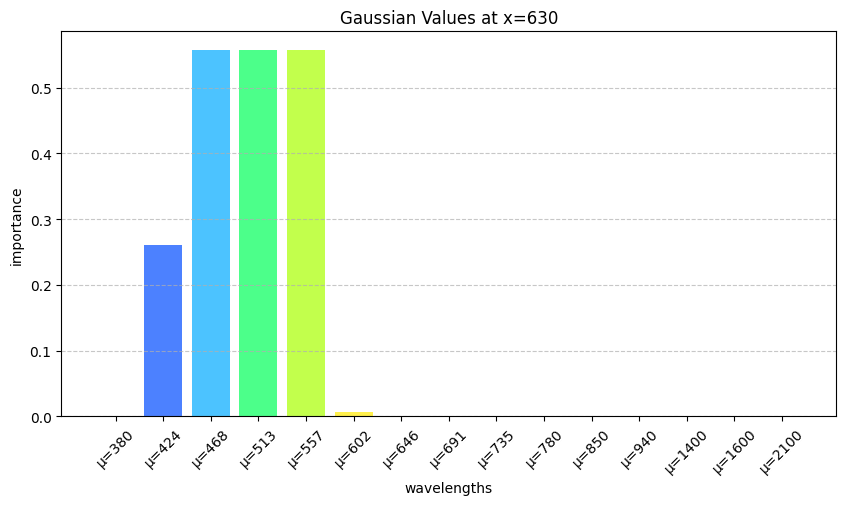

In [38]:
VIS=[380, 424, 468, 513, 557, 602, 646, 691, 735, 780,850,940]
middle=[1400,1600]
centers = VIS+middle+[2100]

# Bandwidths (used as standard deviations)
VIS_std=[15,15,15,15,15,15,15,15,15,15,15,15]
middle_std=[30,40]
stds = VIS_std+middle_std+[120]

# Your spectral band
lambda_center = 500
bandwidth = 115

# Compute encoding
encoding = compute_gaussian_band_encoding(lambda_center, bandwidth, centers, stds)

# Plot bar chart
plt.figure(figsize=(10, 5))
plt.bar(range(len(centers)), encoding, color=colors, alpha=0.7)

# Labeling
plt.xticks(range(len(centers)), [f'μ={mu}' for mu in centers], rotation=45)
plt.xlabel("wavelengths")
plt.ylabel("importance")
plt.title(f"Gaussian Values at x={x_value}")

# Show plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
